# **PRISM ALGORITHM**
## **Heidy Mudita Sutedjo - 0706022310044**

# Installation

The main page for PRISM rules is from https://towardsdatascience.com/prism-rules-in-python-14d2cfd801a3/

In [427]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification, make_blobs, fetch_openml
import sklearn.datasets as datasets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,f1_score
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype


class PrismRules:
    def __init__(self, min_coverage=10, min_prob=0.75, nbins=3, verbose=0):
        """
        Class to generate PRISM rules for a supplied dataset.

        :param min_coverage: The minimum number of rows each rule must cover.
        :param min_prob: The minimum probability for each rule. The target class must be the target value in the
            remaining rows (the rows not covered by previous rules) with at least this probability.
        :param nbins: The number of bins each numeric column is divided into.
        :param verbose: If 0, no output is produced other than the induced rules. If 1, progress indication is
            presented as each rule is induced.
        """

        self.min_coverage = min_coverage
        self.min_prob = min_prob
        self.nbins = nbins
        self.bin_ranges = {}
        self.verbose = verbose
        self.default_target = None
        self.predict_dict = {}
        self.target_column = ""

        # For improved performance, integer values are used for each value. This dictionary maps the integer codes
        # to the original values, and is used to display the rules and target values. Where the column is numeric,
        # this maps to the bin label.
        self.int_to_values_map = {}

    def __get_next_term(self, df, target_col, target_val, cols_exclude_list):
        """
        Get the next term (a column-value pair) for the current rule.

        :param df: The dataframe for the current rule. This is the set of rows matching the rule so far.
        :param target_col: Target column
        :param target_val: The current target value within the target column
        :param cols_exclude_list: Columns for which we already have terms for this rule.
        :return: a single term in tuple format, with a column name and value from that column, along with the
            probability and coverage (frequency) of the rule on the remaining rows.
        """

        max_prob = -1
        # In the event of ties with respect to probability, we take the term with the greatest frequency
        max_prob_freq = 0
        term = None
        for col_name in df.drop(columns=[target_col]).columns:
            if col_name in cols_exclude_list:
                continue
            for val in df[col_name].unique():
                sub_df_1 = df[df[col_name] == val]
                sub_df_2 = df[(df[col_name] == val) & (df[target_col] == target_val)]
                prob = len(sub_df_2) / len(sub_df_1)
                freq = len(sub_df_2)
                if freq < self.min_coverage:
                    continue
                if (prob > max_prob) or ((prob == max_prob) and (freq > max_prob_freq)):
                    max_prob = prob
                    max_prob_freq = freq
                    term = (col_name, val, prob, freq)
        return term

    def __get_next_rule(self, df_rule, target_col, target_val):
        """
        Given a specified target_val in the target_col, find the first or next rule. If not the first, the dataframe
        should just contain rows not covered by the previous rules for this target value.

        :param df_rule: the full original dataframe, minus the rows covered by other rules for the current target
        :param target_col: the target column
        :param target_val: the target value
        :return: a list of terms for the new rule, and a dataframe with the rows for this rule
        """

        terms_list = []
        cols_exclude_list = []  # Do not create terms for the same feature in the same rule
        df = df_rule.copy()
        target_val_remaining = df[target_col].tolist().count(target_val)
        len_df = len(df)
        while target_val_remaining < len_df:
            term = self.__get_next_term(df, target_col, target_val, cols_exclude_list)
            if term is None:
                break
            col, val, prob, freq = term
            cols_exclude_list.append(col)
            if len(cols_exclude_list) == (len(df.columns) - 1):
                break
            df = df[(df[col] == val)]
            terms_list.append((term, df))
            target_val_remaining = df[target_col].tolist().count(target_val)
            len_df = len(df)

        # Check the terms list for the optimal set of terms, which is the set with the highest probability of the
        # target class given the terms.
        max_prob = 0
        max_prob_idx = -1
        max_prob_df = None
        for term_idx, term in enumerate(terms_list):
            if term[0][2] > max_prob:
                max_prob = term[0][2]
                max_prob_idx = term_idx
                max_prob_df = term[1]
        optimal_terms_list = terms_list[:max_prob_idx + 1]
        optimal_terms_list = [x for x, y in optimal_terms_list]

        if max_prob < self.min_prob:
            return None, None

        # Convert the integer codes used in the dataframe to the original values for the relevant column
        formatted_terms = []
        for t in optimal_terms_list:
            if t[1] == "NONE":
                formatted_terms.append(t)
            else:
                formatted_terms.append((t[0], self.int_to_values_map[t[0]][t[1]], t[2], t[3]))

        return formatted_terms, max_prob_df

    def __get_rules_for_target_val(self, df_full, target_col, target_val):
        """
        Get the full set of rules for the specified value in the target column
        :param df_full:
        :param target_col:  Name of target column
        :param target_val:  Value in the target column for which this execution of this function generates rules.
        :return: array of strings.
        """

        rules_for_val = []
        num_rows_curr_target = df_full[target_col].tolist().count(target_val)
        df = df_full.copy()  # Create a temporary dataframe that shrinks as the rules are formed
        is_first_rule = True
        target_val_remaining = df[target_col].tolist().count(target_val)
        while target_val_remaining > self.min_coverage:
            if self.verbose:
                print(f"  Determining next rule. {target_val_remaining:,} rows remaining for target class")
            num_rows_curr_target_remaining = df[target_col].tolist().count(target_val)
            terms_list, rule_df = self.__get_next_rule(df, target_col, target_val)
            if not terms_list:
                break

            if target_val in self.predict_dict:
                self.predict_dict[target_val].append(terms_list)
            else:
                self.predict_dict[target_val] = [terms_list]

            # Add a rule in string format representing the list of terms returned
            rule_str = ""
            for term in terms_list:
                rule_str += str(term[0]) + " = " + str(term[1]) + " AND "
            rule_str = rule_str[:-5]  # Remove the trailing "AND"
            num_matching_target = rule_df[target_col].tolist().count(target_val)
            rule_str += "\n   Support:  "
            if is_first_rule:
                rule_str += f"the target has value: '{self.int_to_values_map[target_col][target_val]}' for "
                rule_str += f"{terms_list[-1][2] * 100:.3f}% of the {num_matching_target} rows matching the rule "
                rule_str += "\n   Coverage: "
                rule_str += f"the rule matches: {num_matching_target} out of {num_rows_curr_target} rows "
                rule_str += f"for target value: '{self.int_to_values_map[target_col][target_val]}'. This is:"
            else:
                rule_str += f"The target has value: '{self.int_to_values_map[target_col][target_val]}' for "
                rule_str += f"{terms_list[-1][2] * 100:.3f}% of the {num_matching_target} remaining rows matching the "
                rule_str += "rule"
                rule_str += "\n   Coverage: "
                rule_str += f"The rule matches: {num_matching_target} out of {num_rows_curr_target_remaining} rows "
                rule_str += f"remaining for target value: '{self.int_to_values_map[target_col][target_val]}'. This is:"
                rule_str += f"\n      {(num_matching_target * 100.0 / num_rows_curr_target_remaining):.3f}% of "
                rule_str += f"remaining rows for target value: '{self.int_to_values_map[target_col][target_val]}'"
            rule_str += f"\n      {(num_matching_target * 100.0 / num_rows_curr_target):.3f}% of total rows for target "
            rule_str += f"value: '{self.int_to_values_map[target_col][target_val]}'"
            rule_str += f"\n      {(num_matching_target * 100.0 / len(df_full)):.3f}% of total rows in data"
            rules_for_val.append(rule_str)
            is_first_rule = False

            # Remove all rows for this rule
            df = df.loc[list(set(df.index) - set(rule_df.index))]
            target_val_remaining = df[target_col].tolist().count(target_val)
        return rules_for_val

    def __display_rules(self, df, target_col, rules_dict, display_stats):
        for target_val in rules_dict:
            print()
            print('........................................................................')
            print(f"Target: {self.int_to_values_map[target_col][target_val]}")
            print('........................................................................')
            if len(rules_dict[target_val]) == 0 and display_stats:
                print((f"  No rules imputed for target value {self.int_to_values_map[target_col][target_val]}. There "
                       f"are {df[target_col].tolist().count(target_val)} rows for this class."))
            for r in rules_dict[target_val]:
                if display_stats:
                    print(r)
                else:
                    print(r.split("\n")[0])

    def get_prism_rules(self, df, target_col, display_stats=True):
        """
        Given a dataframe with a specified target column, find a set of rules that describe the patterns associated
        with the target column. The rules are displayed in a formatted form.

        :param df: pandas dataframe. Must include the target column.
        :param target_col: Name of the target column
        :param display_stats: If True, the support and coverage for each rule will be displayed
        :return: array of strings, with each element of the array representing one rule.
        """

        # PRISM requires all columns be categorical, so bin any numeric features, including the target column if
        # necessary.
        new_vals_dict = {}
        for col_name in df.columns:
            if is_numeric_dtype(df[col_name]) and (df[col_name].nunique() > 10):
                try:
                    if self.nbins == 3:
                        vals = ['Low', "Med", 'High']
                        bin_ids, bin_ranges = pd.qcut(df[col_name], 3, labels=vals, retbins=True)
                    else:
                        vals = [f"Bin_{x}" for x in range(self.nbins)]
                        bin_ids, bin_ranges = pd.qcut(df[col_name], self.nbins, labels=vals, retbins=True)
                    self.bin_ranges[col_name] = bin_ranges
                    vals_to_int_map = {x: y for x, y in zip(vals, range(len(vals)))}
                    int_to_vals_map = {y: x for x, y in zip(vals, range(len(vals)))}
                    new_vals_dict[col_name] = bin_ids.map(vals_to_int_map)
                    self.int_to_values_map[col_name] = int_to_vals_map
                except:
                    # The qcut() method may fail if the data is sufficiently skewed, and the bins are non-unique, In
                    # this case we do not include the column in the model.
                    pass
            else:
                vals = df[col_name].unique()
                vals_to_int_map = {x: y for x, y in zip(vals, range(len(vals)))}
                int_to_vals_map = {y: x for x, y in zip(vals, range(len(vals)))}
                new_vals_dict[col_name] = df[col_name].map(vals_to_int_map)
                self.int_to_values_map[col_name] = int_to_vals_map
        df = pd.DataFrame(new_vals_dict)

        # Remove any columns with only 1 unique value
        drop_cols = []
        for col_name in df.columns:
            if df[col_name].nunique() < 2:
                drop_cols.append(col_name)
        df = df.drop(columns=drop_cols)

        # Fill any NaN and None values
        for col_name in df.columns:
            if df[col_name].dtype.name == "category":
                df[col_name] = df[col_name].cat.add_categories("NONE").fillna("NONE")
            else:
                df[col_name] = df[col_name].fillna("NULL")

        # Loop through each value in the target column and find the set of rules for this value
        target_vals = sorted(df[target_col].unique())
        if self.verbose:
            print(f"Determining rules for each of {len(target_vals)} target classes:")
        rules_dict = {}
        for target_val in target_vals:
            if self.verbose >= 1:
                print(f"Determining rules for target class: {self.int_to_values_map[target_col][target_val]}")
            rules_dict[target_val] = self.__get_rules_for_target_val(df, target_col, target_val)

        self.__display_rules(df, target_col, rules_dict, display_stats)

        self.default_target = df[target_col].mode().values[0]
        self.target_column = target_col

        return rules_dict

    def predict(self, X_in, leave_unknown=False):
        X = X_in.copy()
        X = X.reset_index(drop=True)
        if leave_unknown:
            ret = ["NO PREDICTION"]*len(X)
        else:
            ret = [self.default_target]*len(X)
        is_set = [False]*len(X)

        for col_name in X.columns:
            if col_name not in self.bin_ranges:
                continue
            bin_ranges = self.bin_ranges[col_name]
            for i in range(len(X)):
                v = X.loc[i, col_name]
                for bin_idx, bin_limit in enumerate(bin_ranges):
                    if v < bin_limit:
                        X.loc[i, col_name] = bin_idx - 1
                        break
            if col_name in self.int_to_values_map:
                X[col_name] = X[col_name].map(self.int_to_values_map[col_name])

        for i in range(len(X)):
            row = X.iloc[i]
            found_rule = False
            for key in self.predict_dict.keys():
                rules = self.predict_dict[key]
                for rule in rules:
                    all_terms_true = True
                    for term in rule:
                        term_feature_name = term[0]
                        term_value = term[1]
                        if row[term_feature_name] != term_value:
                            all_terms_true = False
                            break
                    if all_terms_true:
                        ret[i] = key
                        is_set[i] = True
                        found_rule = True
                        break
                if found_rule:
                    break
        ret = pd.Series(ret).map(self.int_to_values_map[self.target_column])
        if leave_unknown:
            ret = ret.fillna("NO PREDICTION")
            ret = ret.astype(str)
        return ret

    def get_bin_ranges(self):
        if self.bin_ranges is None:
            print("No columns were binned.")
        else:
            return self.bin_ranges


# Data Preparation & EDA


In [428]:
# load Wine dataset
pd.set_option('display.max_columns', None)
url = 'https://raw.githubusercontent.com/NathaliaMinoque/datasets/refs/heads/main/wine_data.csv'
df = pd.read_csv(url, sep=',')
df.head(10)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Y
0,13.73,1.50,2.70,22.5,101.0,3.00,3.25,0.29,2.38,5.70,1.19,2.71,1285.0,0
1,14.13,4.10,2.74,24.5,96.0,2.05,0.76,0.56,1.35,9.20,0.61,1.60,560.0,2
2,12.16,1.61,2.31,22.8,90.0,1.78,1.69,0.43,1.56,2.45,1.33,2.26,495.0,1
3,13.07,1.50,2.10,15.5,98.0,2.40,2.64,0.28,1.37,3.70,1.18,2.69,1020.0,0
4,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
5,11.76,2.68,2.92,20.0,103.0,1.75,2.03,0.60,1.05,3.80,1.23,2.50,607.0,1
6,12.08,2.08,1.70,17.5,97.0,2.23,2.17,0.26,1.40,3.30,1.27,2.96,710.0,1
7,13.75,1.73,2.41,16.0,89.0,2.60,2.76,0.29,1.81,5.60,1.15,2.90,1320.0,0
8,13.78,2.76,2.30,22.0,90.0,1.35,0.68,0.41,1.03,9.58,0.70,1.68,615.0,2
9,12.58,1.29,2.10,20.0,103.0,1.48,0.58,0.53,1.40,7.60,0.58,1.55,640.0,2


The unique values in the 'Y' column represent the different class label of Wine, even though the dataset did not provide what each class represent.

In [429]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  Y    

In [430]:
df.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Y
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


The dataset contains 178 entries and 14 columns. All columns have non-null values, meaning there are no missing data points.
Most of the columns are of numerical features, meaning these features will be binned first before generating rules. The target variable 'Y' is categorical.

In [431]:
df = df.sample(n=len(df)) # Shuffle the rows
print("Number of rows:", len(df))

Number of rows: 178


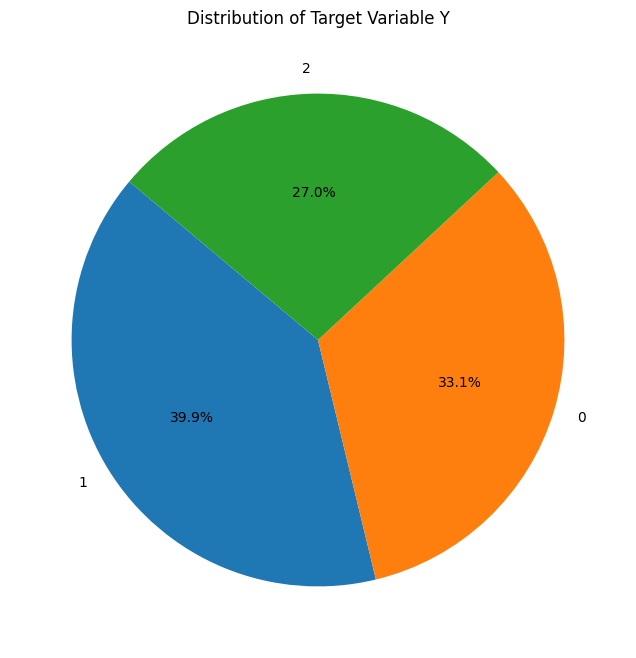

In [432]:
# Get the counts of each unique value in the 'Y' column
y_counts = df['Y'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(y_counts, labels=y_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Target Variable Y')
plt.show()

The pie chart above shows the distribution of the target variable 'Y'. It indicates that the dataset has three classes, with the following distribution:

*   Class 1 is the most frequent, making up approximately 39.9% of the dataset.
*   Class 0 is the second most frequent, accounting for about 33.1% of the dataset.
*   Class 2 is the least frequent, representing approximately 27.0% of the dataset.

This shows that the classes are not perfectly balanced, with class 1 having the highest number of samples and class 2 the lowest, but since it is not drastic, it is still good.

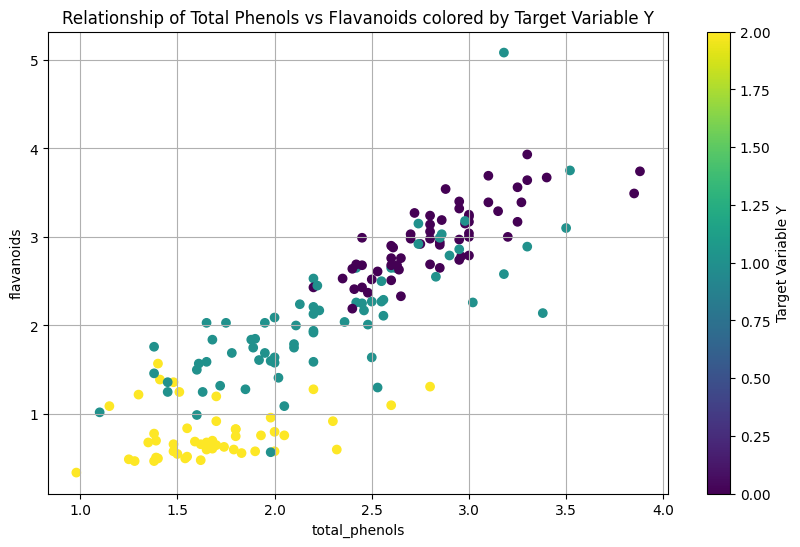

In [433]:
# Scatter plot between Total Phenols vs Flavanoids
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['total_phenols'], df['flavanoids'], c=df['Y'], cmap='viridis')
plt.xlabel('total_phenols')
plt.ylabel('flavanoids')
plt.title(f'Relationship of Total Phenols vs Flavanoids colored by Target Variable Y')
plt.colorbar(scatter, label='Target Variable Y')
plt.grid(True)
plt.show()

This scatter plot visualizes the relationship between 'total_phenols' and 'flavanoids', with points colored according to the target variable 'Y'.

From the plot, it appears that there is a strong positive relationship between 'total_phenols' and 'flavanoids'. As the values of 'total_phenols' increase, the values of 'flavanoids' also tend to increase.

Furthermore, the plot shows some separation of the three classes based on these two features. 'total_phenols' and 'flavanoids' show some potential for differentiating between the wine classes, with some clustering of colors in different areas of the plot.

<Figure size 800x600 with 0 Axes>

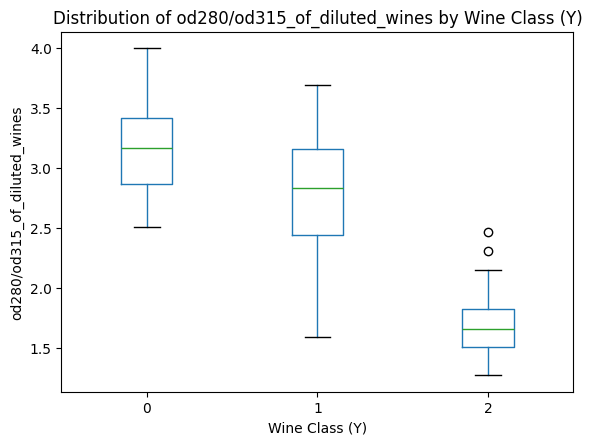

In [434]:
# Create a box plot of 'od280/od315_of_diluted_wines' by 'Y'
plt.figure(figsize=(8, 6))
df.boxplot(column='od280/od315_of_diluted_wines', by='Y', grid=False)
plt.title('Distribution of od280/od315_of_diluted_wines by Wine Class (Y)')
plt.suptitle('') # Suppress the default suptitle
plt.xlabel('Wine Class (Y)')
plt.ylabel('od280/od315_of_diluted_wines')
plt.show()

The box plot shows the distribution of 'od280/od315_of_diluted_wines' for each wine class (Y).

*   **Class 0:** The distribution for Class 0 is higher compared to the other two classes, with the median around 3.2.
*   **Class 1:** Class 1 has a lower distribution than Class 0 and Class 2, with the median around 2.5.
*   **Class 2:** Class 2 has a distribution between Class 0 and Class 1, with the median around 1.7.

This plot clearly shows that 'od280/od315_of_diluted_wines' is a good feature for distinguishing between the wine classes, as the distributions are quite separated for each class.

In [435]:
df['Y'].value_counts()

,count
Y,
1,71
0,59
2,48


# Generate Rules with PRISM

In [436]:
# since we dont do any partitioning bcs we have to use both X and Y in our 'prism' model, so let's just use 100 rows for this training and the rest for the testing

# PRISM requires all columns be categorical, so bin any numeric features, including the target column if necessary, BUT there's a binning function in 'get_prism_rules', so we dont need to binning it manually first.

prism = PrismRules()
_ = prism.get_prism_rules(df.head(125), 'Y')


........................................................................
Target: 1
........................................................................
color_intensity = Low AND alcohol = Low
   Support:  the target has value: '1' for 100.000% of the 32 rows matching the rule 
   Coverage: the rule matches: 32 out of 48 rows for target value: '1'. This is:
      66.667% of total rows for target value: '1'
      25.600% of total rows in data

........................................................................
Target: 2
........................................................................
flavanoids = Low AND color_intensity = Med
   Support:  the target has value: '2' for 100.000% of the 12 rows matching the rule 
   Coverage: the rule matches: 12 out of 33 rows for target value: '2'. This is:
      36.364% of total rows for target value: '2'
      9.600% of total rows in data
flavanoids = Low AND color_intensity = High AND hue = Low
   Support:  The target has value: '2' f

Here is the interpretation of each PRISM rule:

**Class: 1**

*   **Rule:** `color_intensity = Low AND alcohol = Low`
    *   **Interpretation:** If color intensity is Low and alcohol is Low → class 1, meaning wines with low color intensity and low alcohol content tend to belong to class 1.
    *   **Strength:** This rule is very strong and specific, covering 66.667% of total Class 1 rows with 100% support.

**Class: 2**

*   **Rule:** `flavanoids = Low AND color_intensity = Med`
    *   **Interpretation:** If flavanoids is Low and color intensity is Med → class 2, meaning wines with low flavanoids and medium color intensity tend to belong to class 2.
    *   **Strength:** This rule is strong, covering 36.364% of total Class 2 rows with 100% support.

*   **Rule:** `flavanoids = Low AND color_intensity = High AND hue = Low`
    *   **Interpretation:** If flavanoids is Low, color intensity is High, and hue is Low → class 2, meaning wines with low flavanoids, high color intensity, and low hue tend to belong to class 2.
    *   **Strength:** This rule is strong and more specific, covering 60.606% of total Class 2 rows with 100% support.

**Class: 0**

*   **Rule:** `proline = High AND alcohol = High`
    *   **Interpretation:** If proline is High and alcohol is High → class 0, meaning wines with high proline and high alcohol content tend to belong to class 0.
    *   **Strength:** This rule is strong, covering 63.636% of total Class 0 rows with 100% support.

*   **Rule:** `proline = High AND alcohol = Med`
    *   **Interpretation:** If proline is High and alcohol is Med → class 0, meaning wines with high proline and medium alcohol content tend to belong to class 0.
    *   **Strength:** This rule is moderately strong, covering 25.000% of total Class 0 rows with 91.667% support.

# Bin Ranges Result

In [437]:
# This section only to know the range of the bins
bin_ranges_data = []
for col, ranges in prism.get_bin_ranges().items():
    counts, _ = np.histogram(df[col], bins=ranges)
    for i in range(len(ranges) - 1):
        bin_ranges_data.append({
            'Column': col,
            'Bin': i,
            'Lower Bound': ranges[i],
            'Upper Bound': ranges[i+1],
            'Bin': i,
            'Count': counts[i]
        })

bin_ranges_df = pd.DataFrame(bin_ranges_data)
display(bin_ranges_df)

,Column,Bin,Lower Bound,Upper Bound,Count
0,alcohol,0,11.030000,12.546667,61
1,alcohol,1,12.546667,13.516667,63
2,alcohol,2,13.516667,14.750000,53
3,malic_acid,0,0.740000,1.670000,56
4,malic_acid,1,1.670000,2.396667,57
5,malic_acid,2,2.396667,5.800000,65
6,ash,0,1.360000,2.280000,59
7,ash,1,2.280000,2.480000,58
8,ash,2,2.480000,3.230000,61
9,alcalinity_of_ash,0,10.600000,18.000000,53


# Test on Y Pred

In [438]:
# we use the rest of our data for testing, in this case is 50 rows
y_pred = prism.predict(df.tail(53).drop(columns=['Y']))
f1_score(df.tail(53)['Y'], y_pred, average=None)

array([0.8       , 0.88      , 0.96774194])

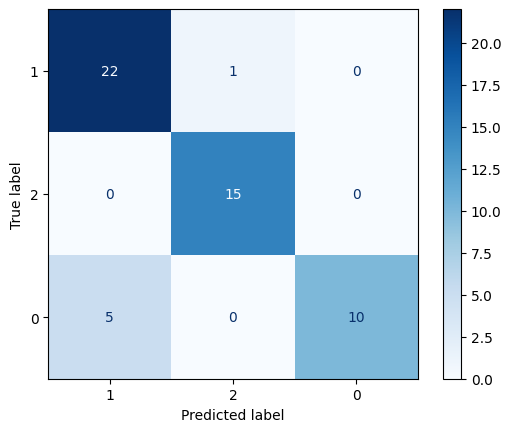

In [439]:
# We next display the confusion matrix.
labels = y_pred.unique()
cm = confusion_matrix(df.tail(53)['Y'], y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.show()

In [440]:
# classification report
from sklearn.metrics import classification_report

print(classification_report(df.tail(53)['Y'], y_pred))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80        15
           1       0.81      0.96      0.88        23
           2       0.94      1.00      0.97        15

    accuracy                           0.89        53
   macro avg       0.92      0.87      0.88        53
weighted avg       0.90      0.89      0.88        53



Based on the confusion matrix and classification report, here is the interpretation:

**Which class is predicted best?**

Looking at the f1-score in the classification report, Class 2 has the highest f1-score (0.97), followed by Class 1 (0.88) and Class 0 (0.80). This suggests that **Class 2 is predicted best** by the PRISM rules on this test set. The high recall (1.00) and precision (0.94) for Class 2 also support this, indicating that almost all actual Class 2 instances were correctly identified, and most of the instances predicted as Class 2 were indeed Class 2.

**Are there misclassifications?**

Yes, there are misclassifications, as shown in the confusion matrix and the precision/recall values less than 1.00 for Classes 0 and 1.

*   **Class 0:** The confusion matrix shows that 10 instances of Class 0 were correctly predicted, but 5 instances of Class 0 were misclassified as Class 1. The precision for Class 0 is 1.00, meaning that when the model predicts Class 0, it is always correct. However, the recall is 0.67, indicating that only 67% of the actual Class 0 instances were correctly identified.
*   **Class 1:** The confusion matrix shows that 22 instances of Class 1 were correctly predicted. However, 1 instance of Class 1 was misclassified as Class 0. The precision for Class 1 is 0.81, meaning that 81% of the instances predicted as Class 1 were actually Class 1. The recall is 0.96, indicating that 96% of the actual Class 1 instances were correctly identified.
*   **Class 2:** The confusion matrix shows that all 15 instances of Class 2 were correctly predicted. There are no misclassifications for Class 2 in this test set, which aligns with its high precision (0.94) and perfect recall (1.00).

In summary, there are some misclassifications between Class 0 and Class 1, but the model performs very well in predicting Class 2.

In [441]:
# Create new data points for the Iris dataset
# You can change these values to test different scenarios
new_data = {
    'alcohol': [14.0, 14.00],
    'malic_acid': [2.0, 2.0],
    'ash': [2.3, 2.2],
    'alcalinity_of_ash': [19.0, 11.0],
    'magnesium': [95.0, 95.0],
    'total_phenols': [2.2, 2.5],
    'flavanoids': [0.14, 0.5],
    'nonflavanoid_phenols': [0.14, 0.5],
    'proanthocyanins': [1.6, 1.5],
    'color_intensity': [7.0, 6.0],
    'hue': [0.7, 0.6],
    'od280/od315_of_diluted_wines': [3.2, 3.0],
    'proline': [550.0, 1400.0]
}

new_df = pd.DataFrame(new_data)

# Predict on the new Iris data using the prism model trained on Wine data
wine_prediction = prism.predict(new_df)
# Assign predictions to a new column in the DataFrame
new_df['Predicted Class'] = wine_prediction

# Display the new data and prediction
print("New Wine Data Points:")
display(new_df)

New Wine Data Points:


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Predicted Class
0,14.0,2.0,2.3,19.0,95.0,2.2,0.14,0.14,1.6,7.0,0.7,3.2,550.0,1
1,14.0,2.0,2.2,11.0,95.0,2.5,0.50,0.50,1.5,6.0,0.6,3.0,1400.0,2


**Data Point 1:**
*   **Predicted Class:** 1
*   **Matching Rule(s):** Based on the binned values (alcohol: High, color_intensity: High), this data point does **not** directly match any of the rules generated by the PRISM model.
    Since no specific rule was matched, PRISM would classify this data point based on the **default target class**. The default target is the mode of the target variable in the training data, which was Class 1.

**Data Point 2:**
*   **Predicted Class:** 2
*   **Matching Rule(s):** Based on the binned values (flavanoids: Low, color_intensity: High, Hue = Low), this data point matches the rule for Target 2: `flavanoids = Low AND color_intensity = High AND hue = Low`.

That's all. Thank you. Gbu